# Urban Traffic Prediction

## Data Preprocessing

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [21]:
# Carregar dados
data = pd.read_csv('improved_traffic_data.csv')

# Imputação de valores ausentes
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Codificação de variáveis categóricas
data_encoded = pd.get_dummies(data_imputed, columns=['day_of_week', 'weather', 'event', 'road_condition'], drop_first=True)

# Conversão para numérico
data_encoded = data_encoded.apply(pd.to_numeric, errors='coerce')

# Remoção de outliers
numeric_cols = data_encoded.select_dtypes(include=[np.number]).columns
z_scores = np.abs(zscore(data_encoded[numeric_cols]))
data_clean = data_encoded[(z_scores < 3).all(axis=1)]

# Remoção de colinearidade
corr_matrix = data_clean.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
data_clean = data_clean.drop(columns=to_drop)

## Modelos

In [22]:
# Separar variáveis
X = data_clean.drop('travel_time', axis=1)
y = data_clean['travel_time']

# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Validação cruzada
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

In [24]:
# Modelo 1: Regressão Linear
lr_model = LinearRegression()
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=rkf, scoring='r2')
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Modelo 2: Random Forest com RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=50, cv=rkf, scoring='r2', n_jobs=-1)
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_
rf_scores = cross_val_score(best_rf, X_train, y_train, cv=rkf, scoring='r2')
y_pred_rf = best_rf.predict(X_test)

# Avaliação
print("Linear Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R²:", r2_score(y_test, y_pred_lr))
print("Cross-Validation R²:", np.mean(lr_scores))

print("\nRandom Forest (tuned):")
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))
print("Cross-Validation R²:", np.mean(rf_scores))

Linear Regression:
MSE: 240.02717119906487
R²: 0.013505604410142924
Cross-Validation R²: -0.00825001635846388

Random Forest (tuned):
MSE: 182.81749741131472
R²: 0.24863324551513188
Cross-Validation R²: 0.17566993429337446


In [25]:
# Comparar os modelos com base no R²
lr_r2 = r2_score(y_test, y_pred_lr)
rf_r2 = r2_score(y_test, y_pred_rf)

if rf_r2 > lr_r2:
    best_model = best_rf
    best_model_name = "Random Forest Regressor"
    y_pred_best_model = y_pred_rf # Previsões do melhor modelo
    mse_best = mean_squared_error(y_test, y_pred_rf)
    rmse_best = np.sqrt(mse_best) # Calcular RMSE para o melhor modelo
    best_model_metrics = {
        "MSE": mse_best,
        "R2": rf_r2,
        "RMSE": rmse_best, # Adicionado RMSE aqui
        "Cross-Validation R2": np.mean(rf_scores),
        "Melhores Hiperparâmetros": random_search.best_params_
    }
else:
    best_model = lr_model
    best_model_name = "Linear Regression"
    y_pred_best_model = y_pred_lr # Previsões do melhor modelo
    mse_best = mean_squared_error(y_test, y_pred_lr)
    rmse_best = np.sqrt(mse_best) # Calcular RMSE para o melhor modelo
    best_model_metrics = {
        "MSE": mse_best,
        "R2": lr_r2,
        "RMSE": rmse_best, # Adicionado RMSE aqui
        "Cross-Validation R2": np.mean(lr_scores)
    }

# Calcular o erro para o melhor modelo
error_best = y_test - y_pred_best_model

# Salvar modelo e informações
joblib.dump(best_model, "best_traffic_model.joblib")

joblib.dump({
    "model_name": best_model_name,
    "metrics": best_model_metrics
}, "best_traffic_model_info.joblib")

# Salvar y_test, y_pred do melhor modelo e o array de erro
joblib.dump(y_test, "traffic_y_test.joblib")
joblib.dump(y_pred_best_model, "traffic_y_pred.joblib")
joblib.dump(error_best, "traffic_prediction_error.joblib")

['traffic_prediction_error.joblib']

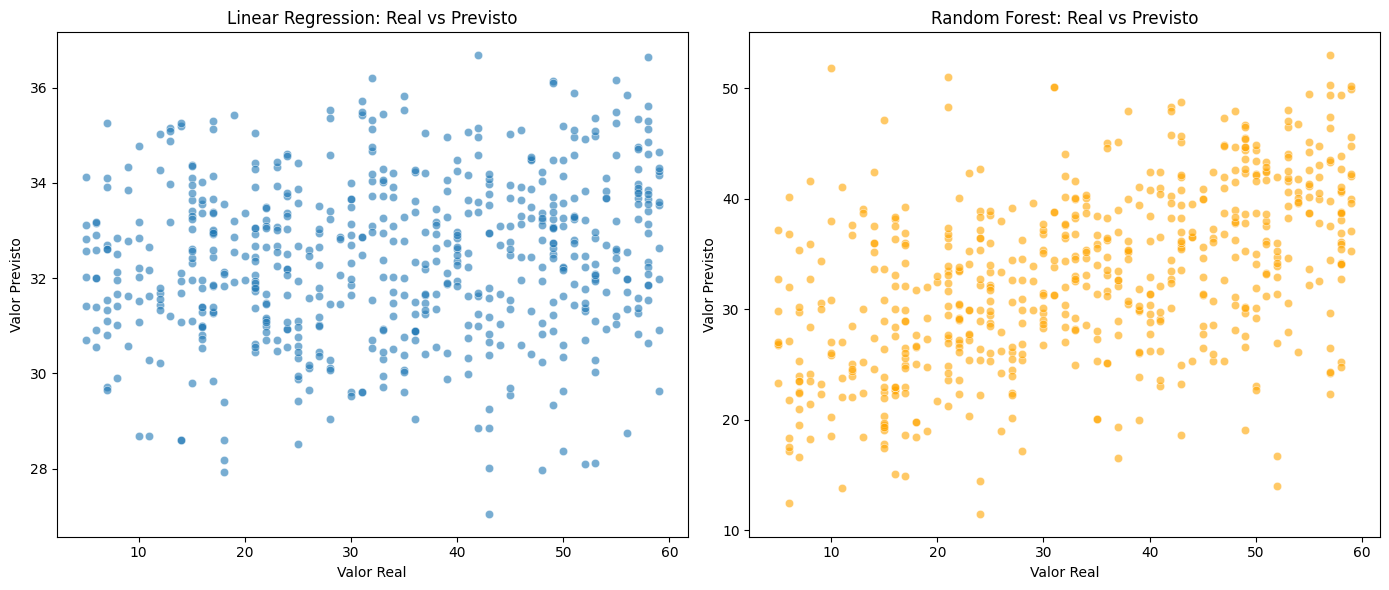

In [26]:
# Gráfico: Previsão vs Real
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6)
plt.title("Linear Regression: Real vs Previsto")
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6, color='orange')
plt.title("Random Forest: Real vs Previsto")
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")
plt.tight_layout()
plt.show()

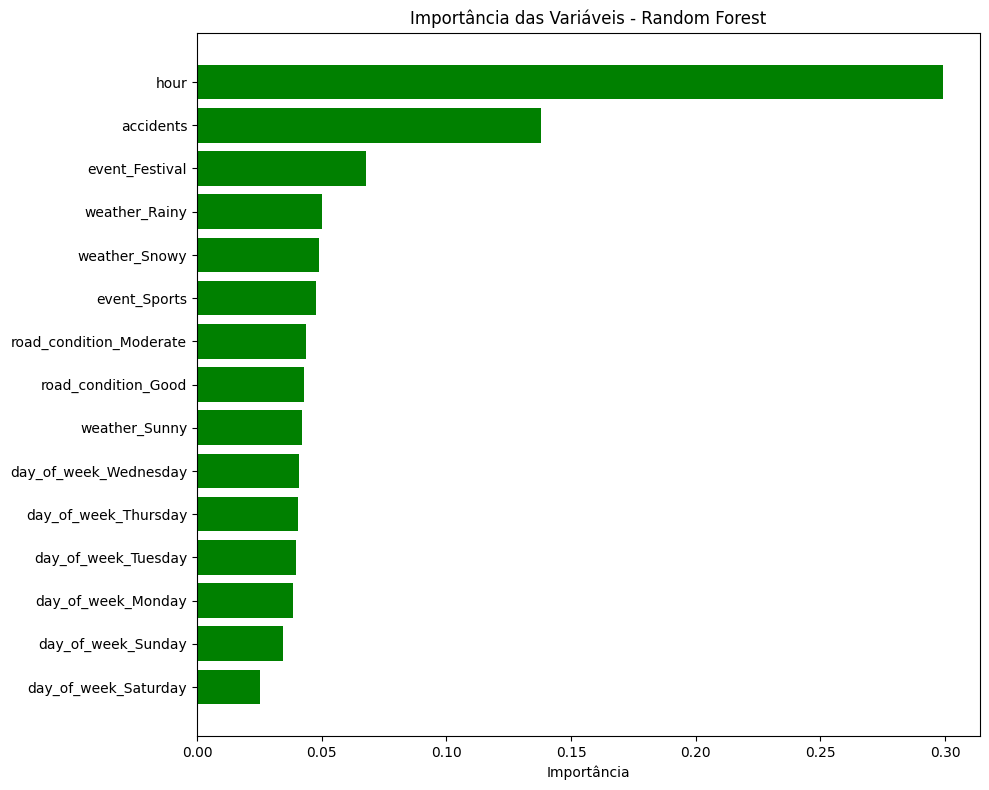

In [27]:
# Importância das variáveis
importances = best_rf.feature_importances_
features = X.columns
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 8))
plt.barh(features[sorted_idx], importances[sorted_idx], color='green')
plt.xlabel("Importância")
plt.title("Importância das Variáveis - Random Forest")
plt.tight_layout()
plt.show()

## Técnicas Utilizadas

### 1. Importações de Bibliotecas

* **`pandas`**: Para manipulação e análise de dados tabulares (DataFrames), essencial para carregar, transformar e limpar os dados.
* **`numpy`**: Fornece suporte para arrays e operações numéricas eficientes, usado em várias etapas, como cálculo de z-scores.
* **`sklearn.model_selection`**:
    * `train_test_split`: Divide o conjunto de dados em subconjuntos de treinamento e teste.
    * `RandomizedSearchCV`: Realiza a otimização de hiperparâmetros de forma aleatória.
    * `RepeatedKFold`: Implementa a validação cruzada k-fold repetida, para uma avaliação mais robusta do modelo.
    * `cross_val_score`: Avalia o desempenho de um modelo usando validação cruzada.
* **`sklearn.linear_model.LinearRegression`**: Implementa o modelo de Regressão Linear, um algoritmo base para regressão.
* **`sklearn.ensemble.RandomForestRegressor`**: Implementa o modelo Random Forest para regressão, um algoritmo de ensemble baseado em árvores de decisão.
* **`sklearn.preprocessing.StandardScaler`**: Padroniza as features removendo a média e escalando para a variância unitária.
* **`sklearn.metrics`**: Módulo que oferece diversas métricas para avaliar o desempenho do modelo (mean_squared_error, r2_score).
* **`sklearn.impute.SimpleImputer`**: Preenche valores ausentes em um conjunto de dados.
* **`scipy.stats.zscore`**: Calcula o Z-score de um array, usado para detecção de outliers.
* **`matplotlib.pyplot` e `seaborn`**: Bibliotecas para visualização de dados, usadas para scatter plots de previsões e gráficos de importância de features.
* **`joblib`**: Usado para salvar e carregar modelos treinados e outras informações relevantes.

### 2. Carregamento de Dados

* **`data = pd.read_csv('improved_traffic_data.csv')`**: Carrega o conjunto de dados, que supostamente contém variáveis relacionadas ao tráfego e o tempo de viagem como variável alvo.

### 3. Pré-processamento e Limpeza de Dados

* **Imputação de Valores Ausentes (`SimpleImputer`)**:
    * `imputer = SimpleImputer(strategy='most_frequent')`: Inicializa um imputador que preenche valores ausentes com o valor mais frequente (moda) de cada coluna.
    * `data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)`: Aplica a imputação aos dados. Esta é uma forma de **tratamento de dados ausentes**.
* **Codificação de Variáveis Categóricas (`pd.get_dummies`)**:
    * `data_encoded = pd.get_dummies(data_imputed, columns=['day_of_week', 'weather', 'event', 'road_condition'], drop_first=True)`: Converte variáveis categóricas (como dia da semana, clima, evento, condição da estrada) em um formato numérico usando **One-Hot Encoding**. `drop_first=True` evita a multicolinearidade, removendo uma das colunas binárias criadas para cada categoria.
* **Conversão para Numérico (`pd.to_numeric`)**:
    * `data_encoded = data_encoded.apply(pd.to_numeric, errors='coerce')`: Garante que todas as colunas sejam numéricas. `errors='coerce'` converte valores que não podem ser transformados em números para `NaN`, que precisariam de tratamento posterior (embora o código não o faça explicitamente após essa etapa, a imputação já ocorreu).
* **Remoção de Outliers (`zscore`)**:
    * `z_scores = np.abs(zscore(data_encoded[numeric_cols]))`: Calcula o Z-score (número de desvios padrão de distância da média) para cada ponto de dados nas colunas numéricas. O valor absoluto é usado para identificar desvios em ambas as direções.
    * `data_clean = data_encoded[(z_scores < 3).all(axis=1)]`: Filtra as linhas onde **qualquer** Z-score (para **qualquer** coluna numérica) é maior ou igual a 3. Esta é uma técnica de **detecção e remoção de outliers** baseada na regra dos 3 sigmas, que assume uma distribuição aproximadamente normal dos dados.
* **Remoção de Colinearidade**:
    * `corr_matrix = data_clean.corr().abs()`: Calcula a matriz de correlação absoluta entre todas as features.
    * `upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))`: Cria uma máscara para pegar apenas a parte superior triangular da matriz de correlação (para evitar duplicações e a diagonal).
    * `to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]`: Identifica as colunas que têm uma correlação absoluta muito alta (maior que 0.95) com outras colunas.
    * `data_clean = data_clean.drop(columns=to_drop)`: Remove as colunas identificadas para reduzir a **multicolinearidade**. Isso ajuda a evitar que modelos lineares superajustem os dados e melhora a interpretabilidade dos coeficientes.

### 4. Preparação para Modelagem

* **Separação de Variáveis**:
    * `X = data_clean.drop('travel_time', axis=1)`: Define as features (variáveis independentes).
    * `y = data_clean['travel_time']`: Define a variável alvo (variável dependente).
* **Normalização/Escalonamento de Features (`StandardScaler`)**:
    * `scaler = StandardScaler()`: Inicializa o padronizador.
    * `X_scaled = scaler.fit_transform(X)`: Padroniza as features `X` para ter média zero e desvio padrão um. Isso é crucial para modelos que são sensíveis à escala das features (como Regressão Linear, modelos baseados em distância, e também melhora a convergência de alguns otimizadores).
* **Divisão Treino/Teste (`train_test_split`)**:
    * `X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)`: Divide os dados em 80% para treinamento e 20% para teste. `random_state` garante a reprodutibilidade.

### 5. Treinamento e Otimização de Modelos

* **Validação Cruzada (`RepeatedKFold`)**:
    * `rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)`: Configura a validação cruzada k-fold repetida. Divide os dados em 5 folds (partes) e repete esse processo 3 vezes. Isso fornece uma estimativa mais robusta do desempenho do modelo, reduzindo a variância da estimativa.
* **Modelo 1: Regressão Linear (`LinearRegression`)**:
    * `lr_model = LinearRegression()`: Inicializa o modelo de Regressão Linear.
    * `lr_scores = cross_val_score(lr_model, X_train, y_train, cv=rkf, scoring='r2')`: Avalia o modelo usando validação cruzada no conjunto de treinamento, medindo o R².
    * `lr_model.fit(X_train, y_train)`: Treina o modelo final de Regressão Linear com todo o conjunto de treinamento.
    * `y_pred_lr = lr_model.predict(X_test)`: Faz previsões no conjunto de teste.
* **Modelo 2: Random Forest Regressor com Otimização de Hiperparâmetros (`RandomizedSearchCV`)**:
    * `param_grid = {...}`: Define o espaço de busca para os hiperparâmetros do Random Forest (número de estimadores, profundidade máxima, mínimo de amostras para split e leaf).
    * `rf = RandomForestRegressor(random_state=42)`: Inicializa o modelo Random Forest.
    * `random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=50, cv=rkf, scoring='r2', n_jobs=-1)`: Realiza a **busca aleatória de hiperparâmetros**.
        * `n_iter=50`: Tenta 50 combinações aleatórias de hiperparâmetros. Mais eficiente que Grid Search para espaços de busca grandes.
        * `n_jobs=-1`: Utiliza todos os núcleos da CPU para paralelizar o processo.
    * `random_search.fit(X_train, y_train)`: Executa a busca pelos melhores hiperparâmetros no conjunto de treinamento.
    * `best_rf = random_search.best_estimator_`: Obtém o modelo Random Forest com os melhores hiperparâmetros encontrados.
    * `rf_scores = cross_val_score(best_rf, X_train, y_train, cv=rkf, scoring='r2')`: Avalia o melhor modelo Random Forest usando validação cruzada.
    * `y_pred_rf = best_rf.predict(X_test)`: Faz previsões no conjunto de teste.

### 6. Avaliação do Modelo

* **Métricas de Regressão**:
    * **MSE (Mean Squared Error)**: `mean_squared_error(y_test, y_pred)`: Média dos quadrados dos erros (diferenças entre valores reais e previstos). Penaliza erros maiores. Quanto menor, melhor.
    * **R² (R-squared)**: `r2_score(y_test, y_pred)`: Coeficiente de determinação. Indica a proporção da variância na variável dependente que é previsível a partir das variáveis independentes. Varia de 0 a 1 (ou pode ser negativo para modelos muito ruins). Quanto mais próximo de 1, melhor o ajuste do modelo.
* Compara o desempenho dos modelos (Regressão Linear e Random Forest) tanto no conjunto de teste quanto com os resultados da validação cruzada.
* Seleciona o "melhor modelo" com base no R² no conjunto de teste.

### 7. Persistência do Modelo

* **`joblib.dump(best_model, "best_traffic_model.joblib")`**: Salva o modelo de melhor desempenho em um arquivo, permitindo seu uso posterior sem retreinamento.
* **`joblib.dump({"model_name": ..., "metrics": ...}, "best_traffic_model_info.joblib")`**: Salva informações sobre o modelo (nome e métricas) em outro arquivo para referência.

### 8. Visualização de Resultados

* **Gráfico de Previsão vs. Real (`scatterplot`)**:
    * Cria gráficos de dispersão comparando os valores reais (`y_test`) com os valores previstos (`y_pred_lr`, `y_pred_rf`) para ambos os modelos. Um modelo ideal teria todos os pontos na linha y=x.
* **Gráfico de Importância das Variáveis (`barh`)**:
    * **`importances = best_rf.feature_importances_`**: Para modelos baseados em árvore como Random Forest, é possível obter a importância de cada feature (o quanto ela contribui para a redução da impureza das folhas).
    * Exibe um gráfico de barras horizontais mostrando as features mais importantes para o modelo Random Forest, o que ajuda na **interpretabilidade do modelo**.


## Possíveis Próximos Passos (Melhorias Futuras)

### 1. Refinamento da Engenharia de Features

* **Features de Tempo:**
    * **Horário do Dia:** Extrair a hora exata ou intervalos de hora (ex: manhã, tarde, pico) pode ser muito relevante.
    * **Dia da Semana (Numérico):** Embora já codificado, considerar a representação numérica ou cíclica (seno/cosseno para horas/dias do ano).
    * **Feriados/Eventos Especiais:** Criar uma feature binária para feriados ou eventos específicos que possam impactar o tráfego de forma significativa.
    * **Tendências Temporais:** Analisar se há tendências de longo prazo ou sazonalidade nos dados.
* **Features de Localização/Rota:** Se os dados contiverem informações sobre a rota ou segmentos de estrada, criar features como distância, número de semáforos, pontos de estrangulamento, etc.
* **Features de Interação:** Criar features que são combinações de outras (ex: `temperatura * umidade` ou `day_of_week * is_peak_hour`).
* **Dados Externos:**
    * **Informações de Tráfego em Tempo Real:** Se disponível, incorporar dados de tráfego ao vivo (velocidade média de outros segmentos, congestionamento) de APIs.
    * **Notícias/Eventos Locais:** Informações sobre acidentes, obras, manifestações, etc.

### 2. Tratamento de Outliers e Valores Ausentes Mais Sofisticado

* **Estratégias de Imputação:**
    * **Imputação por Média/Mediana:** Experimentar imputar com média ou mediana para variáveis numéricas em vez de `most_frequent`.
    * **Imputação Múltipla (MICE):** Gerar múltiplos conjuntos de dados imputados e combinar os resultados do modelo.
    * **Modelos de Imputação:** Treinar um modelo (ex: K-NN Imputer, Iterative Imputer) para prever os valores ausentes com base em outras features.
* **Tratamento de Outliers:**
    * **Métodos Baseados em Distância:** DBSCAN, Isolation Forest, Local Outlier Factor (LOF).
    * **Transformações:** Aplicar transformações logarítmicas ou de Box-Cox para normalizar distribuições e mitigar o impacto de outliers.
    * **Winsorização/Capping:** Limitar os valores extremos a um certo percentil (ex: 1º e 99º percentil).
    * **Análise Contextual:** Investigar a causa dos outliers. Podem ser dados reais de eventos extremos e serem importantes para o modelo.

### 3. Experimentação com Outros Modelos de Regressão

* **Gradient Boosting Machines (GBM):**
    * **XGBoost, LightGBM, CatBoost:** São frequentemente os modelos de melhor desempenho em problemas de regressão tabular, conhecidos por sua velocidade e precisão.
* **Support Vector Regressor (SVR):** Uma versão do SVM para regressão.
* **K-Nearest Neighbors Regressor (KNNRegressor):** Um modelo não-paramétrico baseado em vizinhos mais próximos.
* **Modelos de Redes Neurais (MLPRegressor):** Para dados mais complexos e com muitas features, uma rede neural pode aprender padrões não lineares.
* **Modelos Híbridos/Ensemble:** Combinar as previsões de múltiplos modelos (ex: empilhamento, bagging) para melhorar a robustez e a performance geral.

### 4. Otimização de Hiperparâmetros Mais Abrangente

* **Otimização Bayesiana:** Mais eficiente que Randomized Search para encontrar os melhores hiperparâmetros, especialmente para modelos com muitos hiperparâmetros ou tempo de treinamento longo.
* **Otimização por Algoritmos Genéticos:** Outra alternativa para explorar o espaço de hiperparâmetros.
* **Ajuste de Parâmetros de `StandardScaler` ou outras transformações:** Embora `StandardScaler` não tenha muitos, outras técnicas de escalonamento ou transformação podem ter.

### 5. Avaliação e Validação Mais Robustas

* **Métricas Adicionais:**
    * **MAE (Mean Absolute Error):** Menos sensível a outliers que o MSE.
    * **RMSE (Root Mean Squared Error):** Mesma unidade da variável alvo, facilitando a interpretação.
    * **MAPE (Mean Absolute Percentage Error):** Útil se a precisão relativa for importante.
* **Análise de Resíduos:**
    * Plotar os resíduos (erros de previsão) vs. valores previstos ou vs. features para identificar padrões sistemáticos de erro, o que pode indicar que o modelo está perdendo alguma informação.
* **Curva de Aprendizagem:** Plotar a performance do modelo em relação ao tamanho do dataset de treinamento para identificar se o modelo está sofrendo de alto bias ou alta variância, e se mais dados seriam benéficos.

### 6. Interpretabilidade e Explicabilidade do Modelo

* **SHAP (SHapley Additive exPlanations) / LIME (Local Interpretable Model-agnostic Explanations):** Para entender como features individuais contribuem para previsões específicas, especialmente em modelos mais complexos como Random Forest ou GBM.
* **Partial Dependence Plots (PDPs) / Individual Conditional Expectation (ICE) plots:** Visualizar o efeito marginal de uma ou duas features na previsão do modelo, após contabilizar o efeito de todas as outras features.

### 7. Monitoramento e Implantação em Produção

* **Pipeline de MLOps:** Automatizar as etapas de pré-processamento, treinamento, avaliação e implantação do modelo.
* **Monitoramento Contínuo:** Implementar um sistema para monitorar a performance do modelo em produção (`travel_time` é sensível à deriva de dados). Verificar se o erro de previsão aumenta ou se a distribuição das features de entrada muda ao longo do tempo.
* **Retreinamento Periódico:** Estabelecer uma política para retreinar o modelo com novos dados periodicamente para manter sua relevância e precisão.
* **Testes de Robustez:** Testar o modelo sob condições de tráfego extremas, valores de entrada ausentes ou fora do esperado para garantir que ele se comporte bem.